In [120]:
from tensorflow.keras.applications import EfficientNetB7, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [121]:
#sequencial model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = models.Sequential([
    # base_model,
    # layers.GlobalAveragePooling2D(),

    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2,2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.GlobalAveragePooling2D(),
    
    layers.Flatten(),
    
    # layers.Dense(1000,activation='relu'),
    # layers.Dropout(0.3),
    layers.Dense(1000,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2000, activation='relu'),
    # layers.Dropout(0.3),

    layers.Dense(2, activation = 'softmax')
])

In [122]:
model.build(input_shape = (None, 150, 150, 3))

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1000)                │      67,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 2000)                │       2,002,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │           4,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,508,002 (268.97 MB)

 Trainable params: 70,508,002 (268.97 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
def process_images(directory, label):
    Images = []
    Labels = []
    
    for img in os.listdir(directory):
        path = os.path.join(directory, img)
        
        try:
            with Image.open(path) as img_check:
                img_check.verify()  
            
            image = tf.keras.preprocessing.image.load_img(path, color_mode='rgb', target_size=(150, 150))
            arr = tf.keras.preprocessing.image.img_to_array(image)
            arr = arr / 255.0  
            
            Images.append(arr)
            Labels.append([1, 0] if label == 0 else [0, 1])
        
        except (IOError, OSError, tf.errors.NotFoundError):
            print(f"Skipping invalid image file: {path}")

    Images = np.array(Images)
    Labels = np.array(Labels)
    return Images, Labels

Real2 = '/kaggle/input/new-dataset/New_Data/Real'
AI2 = '/kaggle/input/new-dataset/New_Data/AI'
Real1 = '/kaggle/input/dataset/Train/Real'
AI1 = '/kaggle/input/dataset/Train/AI'

Ai1_arr, Ai1_label = process_images(AI1, 0) 
Real1_arr, Real1_label = process_images(Real1, 1)
Ai2_arr, Ai2_label = process_images(AI2, 0) 
Real2_arr, Real2_label = process_images(Real2, 1)


x_train = np.concatenate((Ai1_arr, Real1_arr, Ai2_arr, Real2_arr), axis=0)
y_train = np.concatenate((Ai1_label, Real1_label, Ai2_label, Real2_label), axis=0)

x_train.shape, y_train.shape

Skipping invalid image file: /kaggle/input/new-dataset/New_Data/AI/image_530.jpg
Skipping invalid image file: /kaggle/input/new-dataset/New_Data/AI/image_326.jpg


((1391, 150, 150, 3), (1391, 2))

In [124]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)

print(x_train.shape, y_train.shape)


(1391, 150, 150, 3) (1391, 2)


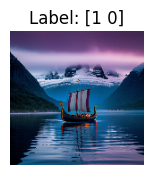

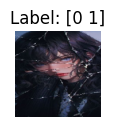

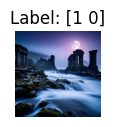

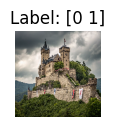

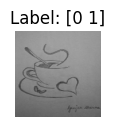

In [125]:
import matplotlib.pyplot as plt

def display_images(images, labels, num_images=5):
    """Display a set of images along with their labels."""
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
        plt.show()

display_images(x_train, y_train, num_images=5)

In [126]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size= 0.3, shuffle = True)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.33, shuffle = True)

In [127]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [128]:
print(x_train.shape)
print(x_val.shape) 
x_test.shape, y_train.shape, y_val.shape, y_test.shape

(973, 150, 150, 3)
(280, 150, 150, 3)


((138, 150, 150, 3), (973, 2), (280, 2), (138, 2))

In [129]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

model.fit(
  x_train, y_train,
  batch_size=32,
  epochs=20,
  validation_data=(x_val, y_val),
  callbacks=[reduce_lr]
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.5246 - loss: 35.5252 - val_accuracy: 0.5750 - val_loss: 1.7783 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6423 - loss: 1.8660 - val_accuracy: 0.8036 - val_loss: 0.4794 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7359 - loss: 0.5692 - val_accuracy: 0.8250 - val_loss: 0.4499 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7804 - loss: 0.5302 - val_accuracy: 0.7786 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 5/20
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7496 - loss: 0.5264
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7521 - loss: 0.5168 - val_accuracy: 0.7036 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7515 - loss: 0.4811 - val_acc

In [130]:
# model.fit(
#     x_train,
#     y_train,
#     batch_size=32,
#     epochs=10,
#     validation_data=(x_val, y_val)
# )

In [131]:
model.evaluate(
    x_test,
    y_test,
    batch_size=32,
    verbose=1,
)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7873 - loss: 0.3483


[0.3126783072948456, 0.8188405632972717]

In [132]:
dir = '/kaggle/input/test-data-new/Test_Images'

dict = {}

def test(directory=dir):
    Images = []
    for img in os.listdir(directory):
        path = os.path.join(directory, img)
        try:
            image = tf.keras.preprocessing.image.load_img(path, color_mode='rgb', target_size=(150, 150))
            arr = tf.keras.preprocessing.image.img_to_array(image)
            arr = arr / 255.0
            Images.append(arr)
            arr = np.array(arr)
            arr = np.expand_dims(arr, axis=0)
            p = model.predict(arr)
            if p[0][0] < p[0][1]:
                dict[img] = "Real"
            else:
                dict[img] = "AI"
        
        except Exception as e:  # Corrected exception handling
            print(f"Error in loading image {img}: {e}")
            dict[img] = "Real"
    return np.array(Images)  # Convert list to numpy array for consistency

main_test = test()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

In [133]:
ai = 0
for e in dict:
    print(e, dict[e])
    if dict[e]== "AI": 
        ai+=1


ai

image_22.jpg Real
image_53.jpg AI
image_141.jpg Real
image_69.jpg AI
image_68.jpg Real
image_175.jpg Real
image_166.jpg AI
image_153.jpg Real
image_176.jpg Real
image_51.jpg Real
image_178.jpg AI
image_88.jpg AI
image_132.jpg AI
image_4.jpg AI
image_75.jpg Real
image_124.jpg Real
image_180.jpg AI
image_179.jpg AI
image_12.jpg Real
image_16.jpg AI
image_125.jpg Real
image_158.jpg AI
image_72.jpg Real
image_58.jpg Real
image_62.jpg Real
image_2.jpg Real
image_45.jpg Real
image_198.jpg Real
image_110.jpg Real
image_7.jpg Real
image_149.jpg Real
image_85.jpg Real
image_107.jpg Real
image_65.jpg AI
image_5.jpg Real
image_86.jpg AI
image_116.jpg Real
image_99.jpg Real
image_36.jpg Real
image_18.jpg AI
image_33.jpg Real
image_19.jpg Real
image_31.jpg AI
image_105.jpg Real
image_27.jpg Real
image_66.jpg AI
image_61.jpg Real
image_172.jpg Real
image_92.jpg AI
image_154.jpg AI
image_11.jpg AI
image_39.jpg AI
image_74.jpg AI
image_79.jpg Real
image_129.jpg AI
image_26.jpg Real
image_28.jpg Real
i

72

In [135]:
import csv

# Raw predictions
predictions = """
image_22.jpg Real
image_53.jpg AI
image_141.jpg Real
image_69.jpg AI
image_68.jpg Real
image_175.jpg Real
image_166.jpg AI
image_153.jpg Real
image_176.jpg Real
image_51.jpg Real
image_178.jpg AI
image_88.jpg AI
image_132.jpg AI
image_4.jpg AI
image_75.jpg Real
image_124.jpg Real
image_180.jpg AI
image_179.jpg AI
image_12.jpg Real
image_16.jpg AI
image_125.jpg Real
image_158.jpg AI
image_72.jpg Real
image_58.jpg Real
image_62.jpg Real
image_2.jpg Real
image_45.jpg Real
image_198.jpg Real
image_110.jpg Real
image_7.jpg Real
image_149.jpg Real
image_85.jpg Real
image_107.jpg Real
image_65.jpg AI
image_5.jpg Real
image_86.jpg AI
image_116.jpg Real
image_99.jpg Real
image_36.jpg Real
image_18.jpg AI
image_33.jpg Real
image_19.jpg Real
image_31.jpg AI
image_105.jpg Real
image_27.jpg Real
image_66.jpg AI
image_61.jpg Real
image_172.jpg Real
image_92.jpg AI
image_154.jpg AI
image_11.jpg AI
image_39.jpg AI
image_74.jpg AI
image_79.jpg Real
image_129.jpg AI
image_26.jpg Real
image_28.jpg Real
image_44.jpg AI
image_14.jpg Real
image_48.jpg AI
image_41.jpg Real
image_10.jpg AI
image_81.jpg Real
image_117.jpg Real
image_47.jpg Real
image_164.jpg Real
image_139.jpg AI
image_155.jpg AI
image_171.jpg Real
image_30.jpg AI
image_142.jpg AI
image_186.jpg Real
image_170.jpg AI
image_77.jpg Real
image_156.jpg Real
image_59.jpg Real
image_119.jpg Real
image_23.jpg Real
image_106.jpg Real
image_60.jpg Real
image_101.jpg AI
image_63.jpg AI
image_34.jpg AI
image_190.jpg AI
image_94.jpg AI
image_144.jpg Real
image_50.jpg Real
image_109.jpg AI
image_104.jpg AI
image_32.jpg Real
image_70.jpg Real
image_83.jpg AI
image_152.jpg AI
image_145.jpg AI
image_184.jpg AI
image_98.jpg Real
image_118.jpg Real
image_21.jpg AI
image_197.jpg Real
image_95.jpg Real
image_93.jpg Real
image_131.jpg Real
image_25.jpg Real
image_0.jpg Real
image_17.jpg Real
image_196.jpg Real
image_160.jpg AI
image_183.jpg Real
image_87.jpg Real
image_136.jpg AI
image_96.jpg Real
image_15.jpg Real
image_165.jpg AI
image_188.jpg Real
image_54.jpg Real
image_122.jpg Real
image_90.jpg Real
image_1.jpg Real
image_147.jpg Real
image_189.jpg AI
image_13.jpg Real
image_163.jpg Real
image_103.jpg AI
image_89.jpg Real
image_151.jpg Real
image_43.jpg Real
image_187.jpg Real
image_40.jpg Real
image_115.jpg Real
image_174.jpg Real
image_199.jpg Real
image_91.jpg Real
image_177.jpg Real
image_146.jpg AI
image_97.jpg Real
image_162.jpg Real
image_102.jpg Real
image_194.jpg Real
image_112.jpg AI
image_134.jpg Real
image_56.jpg Real
image_121.jpg AI
image_55.jpg AI
image_167.jpg AI
image_127.jpg AI
image_78.jpg Real
image_157.jpg Real
image_35.jpg AI
image_133.jpg AI
image_80.jpg Real
image_168.jpg Real
image_42.jpg Real
image_138.jpg Real
image_8.jpg AI
image_169.jpg Real
image_161.jpg AI
image_84.jpg Real
image_38.jpg Real
image_67.jpg AI
image_46.jpg Real
image_49.jpg AI
image_3.jpg Real
image_159.jpg Real
image_193.jpg Real
image_173.jpg Real
image_143.jpg Real
image_123.jpg Real
image_100.jpg Real
image_20.jpg Real
image_148.jpg AI
image_185.jpg Real
image_111.jpg Real
image_114.jpg AI
image_195.jpg Real
image_64.jpg Real
image_140.jpg Real
image_52.jpg AI
image_24.jpg Real
image_120.jpg Real
image_73.jpg AI
image_76.jpg Real
image_108.jpg AI
image_29.jpg Real
image_192.jpg AI
image_181.jpg AI
image_130.jpg Real
image_57.jpg AI
image_37.jpg AI
image_6.jpg Real
image_113.jpg AI
image_182.jpg AI
image_137.jpg Real
image_126.jpg AI
image_128.jpg Real
image_9.jpg Real
image_150.jpg Real
image_135.jpg AI
image_71.jpg Real
image_191.jpg Real
image_82.jpg Real
"""

# Parse predictions
data = []
for line in predictions.strip().split("\n"):
    image_name, label = line.replace(".jpg", "").split()
    image_number = int(image_name.split("_")[1])
    data.append((image_number, image_name, label))

# Sort by image number
data.sort(key=lambda x: x[0])

# Save to CSV
output_file = "predictions.csv"
with open(output_file, mode="w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Id", "Label"])
    for _, image_name, label in data:
        csv_writer.writerow([image_name, label])

print(f"CSV file saved as {output_file}.")


CSV file saved as predictions.csv.
